<a href="https://colab.research.google.com/github/buxkirill/reboot_DA/blob/main/final_project/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime, date, timedelta
import requests
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from matplotlib.patches import Ellipse
warnings.filterwarnings('ignore')
# формат чисел
#pd.options.display.float_format ='{:,.3f}'.format


# Постановка задачи

Определение доходности облигаций по данным ММВБ
Disclaimer: данное задание подготовлено исключительно для тренировки навыков
анализа данных, результаты выполнения задания не являются рекомендациями по
операциям с облигациями, автор задания не является инвестиционным
консультантом.
Имеются данные по облигациям, которые торгуются на ММВБ на текущую дату.
Требуется выполнить следующие действия с данными по облигациям на дату
формирования данных:
1. Оценить рынок рублевых облигаций по распределению купонной доходности,
предложить разделение на кластеры по купонной доходности.
Предложить графическое представление полученных групп/кластеров. (график)
2. По низкорисковым рублевым облигациям с датой промежуточной выплаты по
купонам не более 20% купонного периода назад до текущей даты и облигациям
выпущенным в аналогичный период, рассчитать доходность последующих
купонов по отобранным облигациям с учетом разницы номинала и цены продажи,
а также с учетом налоговых отчислений на период год с текущей дата. (график
и/или таблица).
3. Допускается обоснованное изменение условий как по критериям оценки рынка,
так с учетом выбранной стратегии инвестирования.
Датасет с данными расположен по адресу:
https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.
%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&li
mit=unlimited&lang=ru
На усмотрение слушателя:
• можно скачать и загрузить в вашем скрипте файл csv (например,
pd.read_csv с указанием русской кодировки, релевантного знака
сепарирования и номера строки заголовков),
• загружать on-line:
s=requests.get(bond_url).content
pd.read_csv(io.StringIO(s.decode('УКАЗАТЬ КОДИРОВКУ')), sep='СЕПАПРАТОР', header=№ СТРОКИ
ЗАГОЛОВКОВ)
Могут быть использованы следующие поля (а также все остальные) в любых
комбинациях:

'SECID' - Код ценной бумаги,
'SHORTNAME' - Краткое наименование,
'NAME' Полное наименование,
'FACEVALUE' - Номинальная стоимость,
FACEUNIT' - валюта,
'DURATION' - дюрация,
'IS_QUALIFIED_INVESTORS' - признак продукта для квалифицированных инвесторов,
'HIGH_RISK' - признак уровня риска,
'COUPONFREQUENCY' – число купонов в год,
'COUPONDATE' - Дата выплаты купона,
'COUPONPERCENT' - Ставка купона, %,
'COUPONVALUE' - Сумма купона, в валюте номинала, 
'OFFERDATE' - Дата оферты,
'EMITENTNAME' – наименование эмитента,
'INN' – ИНН эмитента,
'PRICE' – текущий % от FACEVALUE,
'PRICE_RUB' - котировка,

Пояснения:
1. Для получения текущей даты можно использовать метод datetime.date.today();

2. Период расчета доходности рекомендуется выбирать 365 дней с текущей даты;

3. Нужно учитывать накопленный купонный доход (НКД) и разницу котировки и номинала ;

4. В общем случае процентный доход при ставке НДФЛ 13% будет
Profit =(Цена_Номинальная – Цена_покупки – НКД + 0.87*Купонный_доход_руб*X_лет)*100% /(Цена_покупки + НКД) (комиссией брокера
пренебрегаем)

5. Период расчета НКД: df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется
выбирать меньше или равный 0.2.
Если удовлетворяет условию, полученная величина умножается
на COUPONPERCENT/COUPONFREQUENCY.

6. Датасет содержит данные, которые нужно преобразовывать в форматы python, а также
пустые и искаженные данные, с которыми нужно что-то решить.

In [19]:
df.isna().sum()

SECID                        0
SHORTNAME                    0
NAME                         0
TYPENAME                     0
ISIN                         0
REGNUMBER                  384
LISTLEVEL                  254
FACEVALUE                    0
FACEUNIT                     0
ISSUESIZE                   19
IS_COLLATERAL                0
IS_EXTERNAL                  0
PRIMARY_BOARDID              0
PRIMARY_BOARD_TITLE          0
MATDATE                     48
IS_RII                    2662
DURATION                   848
ISSUEDATE                  145
EVENINGSESSION               0
IS_QUALIFIED_INVESTORS       0
HIGH_RISK                    0
COUPONFREQUENCY            374
YIELDATWAP                1457
COUPONDATE                  14
COUPONPERCENT              116
COUPONVALUE                116
COUPONDAYSPASSED            14
COUPONDAYSREMAIN            14
COUPONLENGTH                14
ISSUEDATE.1                145
INITIALFACEVALUE             0
SECSUBTYPE                2545
STARTDAT

# Описание данных

Текстовые:
1. **SECID** - Код ценной бумаги. non-null
2. **SHORTNAME**- Краткое наименование. non-null
3. '**NAME**' - Полное наименование. non-null
4. '**ISIN**' - ISIN код. non-null
5. '**PRIMARY_BOARD_TITLE**' - Режим торгов. non-null
6. '**REGNUMBER**' - номер выпуска. 
7. '**EMITENTNAME**' – наименование эмитента. 
8. '**INN**' – ИНН эмитента. 

Бинарные:
9. 'IS_COLLATERAL' - . non-null
10. '**IS_EXTERNAL**' - внешний. non-null
11. '**EVENINGSESSION**' - Вечерняя сессия. non-null
12. **IS_QUALIFIED_INVESTORS** - признак продукта для 
квалифицированных инвесторов. non-null
13. '**HIGH_RISK**' - признак уровня риска. non-null

Категориальные:
14. '**LISTLEVEL**' - Уровень листинга
15. '**TYPENAME**' - Вид/категория ценной бумаги. non-null
16. '**FACEUNIT**' - валюта. non-null
17. '**PRIMARY_BOARDID**' - Идентификатор режима торгов. non-null
18. '**SECSUBTYPE**' - Подтип облигации. очень много null
19. 'IS_RII' - . очень много null

Временные:
20. '**MATDATE**' - Дата погашения
21. '**ISSUEDATE**' - Дата начала торгов
22. '**COUPONDATE**' - Дата выплаты купона
23. '**ISSUEDATE.1**' - Дата начала торгов
24. '**STARTDATEMOEX**' - Дата начала торгов на Московской Бирже
25. '**OFFERDATE**' - Дата оферты

Вещественные:
26. '**FACEVALUE**' - Номинальная стоимость. non-null
27. '**INITIALFACEVALUE**' - Номинальная стоимость. non-null
28. '**DAYSTOREDEMPTION**' - Дней до погашения
29. '**LOTSIZE**' - Размер лота, ц.б. non-null
30. '**PRICE**' – текущий % от FACEVALUE
31. '**PRICE_RUB**' - котировка
32. '**DURATION**' - дюрация
33. '**COUPONFREQUENCY**' – число купонов в год
34. '**YIELDATWAP**' - Доходность по средневзвешенной цене. очень много null
35. '**COUPONPERCENT**' - Ставка купона
36. '**COUPONVALUE**' - Сумма купона
37. '**COUPONDAYSPASSED**' - прошло дней с выплаты купона
38. '**COUPONDAYSREMAIN**' - дней до выплаты купона
39. '**COUPONLENGTH**' - периодичность выплаты купона
40. '**ISSUESIZE**' - Объем выпуска


Прочие:
41. 'RTL1'
42. 'RTH1'
43. 'RTL2'
44. 'RTH2'
45. 'RTL3'
46. 'RTH3'
47. 'DISCOUNT1' non-null
48. 'LIMIT1'
49. 'DISCOUNT2'
50. 'LIMIT2'
51. 'DISCOUNT3'
52. 'DISCOUNTL0'
53. 'DISCOUNTH0'

# Загрузка и предобработка данных от 08.10.2021

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1kerEidv4dqdOUqeKHDgGHidY5uHZohGn' -O './rates.csv'
KEY_RATE = pd.read_html('https://www.cbr.ru/hd_base/KeyRate/')[0]['Ставка'][0]/100
INVEST_PERIOD = 365
TAX_RATE = 0.13

In [4]:
df = pd.read_csv('rates.csv', sep=';', header=1, encoding='cp1251', dtype={'INN': 'string', 'LISTLEVEL': 'object'})
df.sample(5)

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,IS_COLLATERAL,IS_EXTERNAL,PRIMARY_BOARDID,PRIMARY_BOARD_TITLE,MATDATE,IS_RII,DURATION,ISSUEDATE,EVENINGSESSION,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,YIELDATWAP,COUPONDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,ISSUEDATE.1,INITIALFACEVALUE,SECSUBTYPE,STARTDATEMOEX,DAYSTOREDEMPTION,OFFERDATE,EMITENTNAME,INN,LOTSIZE,PRICE,PRICE_RUB,RTL1,RTH1,RTL2,RTH2,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0
1121,RU000A1010D3,Якут-13 об,Республика Саха (Якутия) об.13,Региональные облигации,RU000A1010D3,RU35013RSY0,1,"1000,0",RUB,5000000.0,0,0,TQCB,Т+: Облигации - безадрес.,02.11.2026,NaN,994.0,11.11.2019,0,0,0,4.0,NaN,08.11.2021,"6,950","17,33",60.0,31.0,91.0,11.11.2019,"1000,0",NaN,2019-11-11,1851.0,NaN,Министерство финансов Республики Саха (Якутия),1435027673,1,"97,8","989,42","850,9","1127,94","821,22","1157,62","791,54","1187,3","14,0",100000.0,"17,0",500000.0,"20,0",NaN,NaN
1085,RU000A100XB4,СберИОС145,СберИОС001Р-145R 4.5Y O.G.100%,Биржевые облигации,RU000A100XB4,4B0214401481B001P,3,"1000,0",RUB,341320.0,0,0,TQCB,Т+: Облигации - безадрес.,15.04.2024,NaN,920.0,15.10.2019,0,0,0,NaN,NaN,15.04.2024,"1,055","47,52",724.0,920.0,1644.0,15.10.2019,"1000,0",NaN,2019-10-15,920.0,NaN,"Публичное акционерное общество ""Сбербанк России""",7707083893,1,"103,38","1033,8",NaN,"2067,6",NaN,"2067,6",NaN,"2067,6","100,0",NaN,NaN,NaN,NaN,NaN,NaN
907,RU000A100A66,МТС 1P-09,Мобильные ТелеСистемы 001P-09,Биржевые облигации,RU000A100A66,4B02-09-04715-A-001P,1,"1000,0",RUB,7500000.0,0,0,TQCB,Т+: Облигации - безадрес.,14.10.2024,NaN,966.0,22.04.2019,0,0,0,4.0,"7,5",18.10.2021,"8,600","21,44",81.0,10.0,91.0,22.04.2019,"1000,0",NaN,2019-04-22,1102.0,NaN,"Публичное акционерное общество ""Мобильные Теле...",7740000076,1,"102,99","1048,98","891,63","1206,33","860,16","1237,8","828,69","1269,27","15,0",150000.0,"18,0",750000.0,"21,0","10,00","10,00"
842,RU000A100451,СберИОС61,Сбербанк ПАО ИОС 001P-61R,Биржевые облигации,RU000A100451,4B025901481B001P,3,"1000,0",RUB,920441.0,0,0,TQCB,Т+: Облигации - безадрес.,29.08.2022,NaN,325.0,19.02.2019,0,0,0,NaN,NaN,29.08.2022,"1,350","47,6",962.0,325.0,1287.0,19.02.2019,"1000,0",NaN,2019-02-19,325.0,NaN,"Публичное акционерное общество ""Сбербанк России""",7707083893,1,"122,28","1222,8",NaN,"2445,6",NaN,"2445,6",NaN,"2445,6","100,0",NaN,NaN,NaN,NaN,"18,00","12,00"
2493,XS1949598855,BCS 02/22,BCS SP Plc Series 35,Корпоративные еврооблигации,XS1949598855,NaN,3,"1000,0",EUR,5000.0,0,1,TQOE,Т+: Облигации (EUR) - безадрес.,28.02.2022,NaN,140.0,07.02.2019,1,1,0,4.0,"0,0",28.11.2021,"10,000","25,0",39.0,51.0,90.0,07.02.2019,"1000,0",NaN,2019-02-12,143.0,NaN,БрокерКредитСервис Стракчэрд Продактс ПиЭлСи (...,0010035220,1,"99,98","83055,69",NaN,"166111,38",NaN,"166111,38",NaN,"166111,38","100,0",NaN,NaN,NaN,NaN,"100,00","100,00"


In [10]:
USELESS_COLS = [#'SECID', 
                'SHORTNAME', 'NAME', 'ISIN', 'REGNUMBER', 'EMITENTNAME', 'INN', 'LOTSIZE', 'PRIMARY_BOARD_TITLE' , 'INITIALFACEVALUE', 'ISSUESIZE']

CATEGORICAL_COLS = ['TYPENAME', 'LISTLEVEL', 'FACEUNIT', 'PRIMARY_BOARDID', 'SECSUBTYPE', 'IS_RII']

BINARY_COLS = ['IS_COLLATERAL', 'IS_EXTERNAL', 'IS_QUALIFIED_INVESTORS', 'EVENINGSESSION', 'HIGH_RISK']

DATE_COLS = ['MATDATE', 'ISSUEDATE', 'COUPONDATE', 'ISSUEDATE.1', 'STARTDATEMOEX', 'OFFERDATE']

COLS_CONVERT_TO_FLOAT = ['FACEVALUE', 'COUPONPERCENT', 'COUPONVALUE', 'PRICE', 'PRICE_RUB', 'RTL1', 'RTH1', 'RTL2', 'RTH2', 'RTL3', 'RTH3', 'DISCOUNT1', 'DISCOUNT2', 'DISCOUNT3', 'DISCOUNTL0', 'DISCOUNTH0']

In [11]:
# удаляем не нужные столбцы
# df.drop(USELESS_COLS, axis=1, inplace=True)

# изменяем формат временных колонок
for col in DATE_COLS:
  df[col] = pd.to_datetime(df[col])

# изменяем формат численных колонок
for col in COLS_CONVERT_TO_FLOAT:
  df[col] = df[col].str.replace(',', '.').astype('float64')


In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isna().sum()

# Кластеризация

Попробуем сделать кластеризацию по бинарным, категориальным и вещественным ненулевым признакам

### Кластеризация всех облигаций

In [281]:
clustering_df = df.copy()

In [282]:
clustering_df = pd.get_dummies(clustering_df[CATEGORICAL_COLS + BINARY_COLS + ['PRICE', 'COUPONPERCENT']], columns=CATEGORICAL_COLS).dropna()

In [283]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_df)

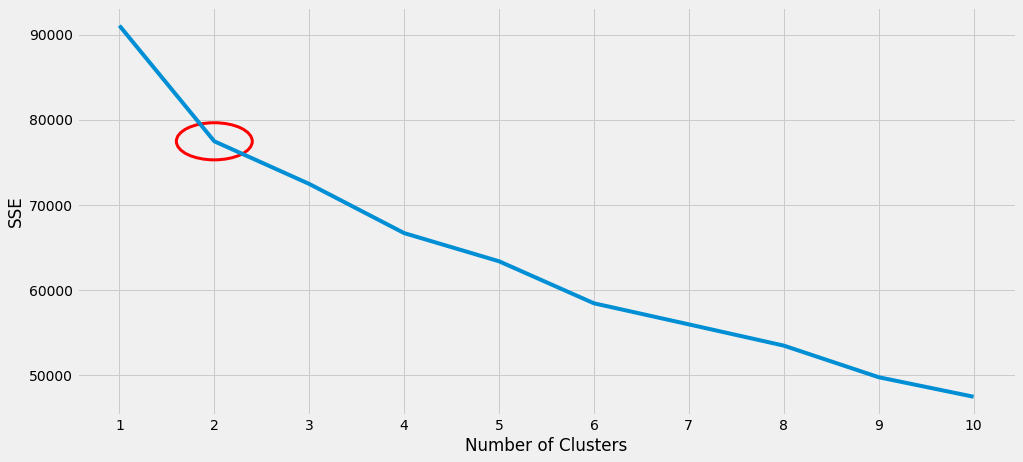

In [284]:
sse = []
kmeans_kwargs = {"init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 999}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(15,7))
ellipse = Ellipse((2, sse[1]), 
                  height=(max(sse) - min(sse)) / len(sse), 
                  width=0.8,
                  edgecolor='r',
                  fill=False,
                  linewidth=3)

ax.plot(range(1, 11), sse)
ax.add_patch(ellipse)
ax.set_xticks(range(1, 11))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")

plt.show()

In [285]:
kmeans = KMeans(init="random",
                n_clusters=2,
                n_init=10,
                max_iter=300,
                random_state=999)

kmeans.fit(scaled_features)
clustering_df['Cluster'] = kmeans.labels_
clustering_df.Cluster.value_counts()

1    2086
0     310
Name: Cluster, dtype: int64

In [224]:
clustering_df[clustering_df.Cluster==0].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Еврооблигации МинФина,TYPENAME_Коммерческая облигация,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,TYPENAME_Муниципальные облигации,TYPENAME_ОБР,TYPENAME_ОФЗ,TYPENAME_Облигации государств,TYPENAME_Региональные облигации,LISTLEVEL_1,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_CHF,FACEUNIT_CNY,FACEUNIT_EUR,FACEUNIT_GBP,FACEUNIT_RUB,FACEUNIT_USD,PRIMARY_BOARDID_OBBO,PRIMARY_BOARDID_PSAU,PRIMARY_BOARDID_PSBB,PRIMARY_BOARDID_RPMO,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQIR,PRIMARY_BOARDID_TQIU,PRIMARY_BOARDID_TQOB,PRIMARY_BOARDID_TQOD,PRIMARY_BOARDID_TQOE,PRIMARY_BOARDID_TQRD,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Структурные облигации,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.0,310.000000,310.00000,310.0,310.0,310.0,310.000000,310.0,310.000000,310.0,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.0,310.0,310.0,310.000000,310.000000,310.0,310.000000,310.0,310.000000,310.000000,310.0,310.0,310.0,310.000000,310.0,310.0,310.0
mean,0.300000,0.993548,0.648387,0.645161,0.003226,102.630548,5.886081,0.029032,0.048387,0.0,0.822581,0.06129,0.0,0.0,0.0,0.038710,0.0,0.064516,0.0,0.670968,0.029032,0.003226,0.119355,0.006452,0.119355,0.722581,0.0,0.0,0.0,0.264516,0.109677,0.0,0.003226,0.0,0.538710,0.083871,0.0,0.0,0.0,0.087097,0.0,0.0,0.0
std,0.458998,0.080192,0.478246,0.479238,0.056796,10.780493,3.027671,0.168168,0.214930,0.0,0.382641,0.24025,0.0,0.0,0.0,0.193214,0.0,0.246067,0.0,0.470621,0.168168,0.056796,0.324730,0.080192,0.324730,0.448449,0.0,0.0,0.0,0.441788,0.312992,0.0,0.056796,0.0,0.499305,0.277642,0.0,0.0,0.0,0.282433,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,45.240000,0.010000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
25%,0.000000,1.000000,0.000000,0.000000,0.000000,99.212500,4.000000,0.000000,0.000000,0.0,1.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
50%,0.000000,1.000000,1.000000,1.000000,0.000000,102.115000,5.375000,0.000000,0.000000,0.0,1.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
75%,1.000000,1.000000,1.000000,1.000000,0.000000,105.657500,7.500000,0.000000,0.000000,0.0,1.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,164.970000,19.000000,1.000000,1.000000,0.0,1.000000,1.00000,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0


In [225]:
clustering_df[clustering_df.Cluster==1].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Еврооблигации МинФина,TYPENAME_Коммерческая облигация,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,TYPENAME_Муниципальные облигации,TYPENAME_ОБР,TYPENAME_ОФЗ,TYPENAME_Облигации государств,TYPENAME_Региональные облигации,LISTLEVEL_1,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_CHF,FACEUNIT_CNY,FACEUNIT_EUR,FACEUNIT_GBP,FACEUNIT_RUB,FACEUNIT_USD,PRIMARY_BOARDID_OBBO,PRIMARY_BOARDID_PSAU,PRIMARY_BOARDID_PSBB,PRIMARY_BOARDID_RPMO,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQIR,PRIMARY_BOARDID_TQIU,PRIMARY_BOARDID_TQOB,PRIMARY_BOARDID_TQOD,PRIMARY_BOARDID_TQOE,PRIMARY_BOARDID_TQRD,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Структурные облигации,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.0,2086.0,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.0,2086.00000,2086.000000,2086.000000,2086.000000,2086.0,2086.0,2086.0,2086.0,2086.000000,2086.000000,2086.0,2086.0,2086.0,2086.0,2086.000000,2086.000000,2086.0,2086.000000,2086.0,2086.0,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.0
mean,0.132790,0.008629,0.083413,0.033557,0.076702,98.417589,6.068413,0.765101,0.0,0.0,0.011026,0.140460,0.004794,0.001438,0.022531,0.0,0.05465,0.254554,0.156280,0.589166,0.0,0.0,0.0,0.0,0.990412,0.009588,0.0,0.0,0.0,0.0,0.899329,0.058485,0.0,0.023969,0.0,0.0,0.018217,0.022531,0.002876,0.017737,0.001438,0.007191,1.0
std,0.339429,0.092513,0.276572,0.180129,0.266182,13.833235,4.194630,0.424038,0.0,0.0,0.104449,0.347547,0.069088,0.037905,0.148439,0.0,0.22735,0.435715,0.363208,0.492103,0.0,0.0,0.0,0.0,0.097470,0.097470,0.0,0.0,0.0,0.0,0.300965,0.234715,0.0,0.152990,0.0,0.0,0.133766,0.148439,0.053567,0.132027,0.037905,0.084513,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.010000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,96.980000,0.962500,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,99.900000,7.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,100.930000,8.800000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,198.210000,16.310000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.00000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


##### Различие между кластерами

**IS_EXTERNAL**:

0 кластер - 99%

1 кластер - 1%

**IS_QUALIFIED_INVESTORS**:

0 кластер - 64%

1 кластер - 8%

**EVENINGSESSION**

0 кластер - 67%

1 кластер - 3%

**TYPENAME_Биржевые облигации**:

0 кластер - 3%

1 кластер - 77%

**TYPENAME_Корпоративные еврооблигации**

0 кластер - 82%

1 кластер - 1%

**Инвалюта**:

0 кластер - 90%

1 кластер - 1%

**boardid**:

0 кластер - 56% на TQOD, 24% на RPMO

1 кластер - 90% на TQCB



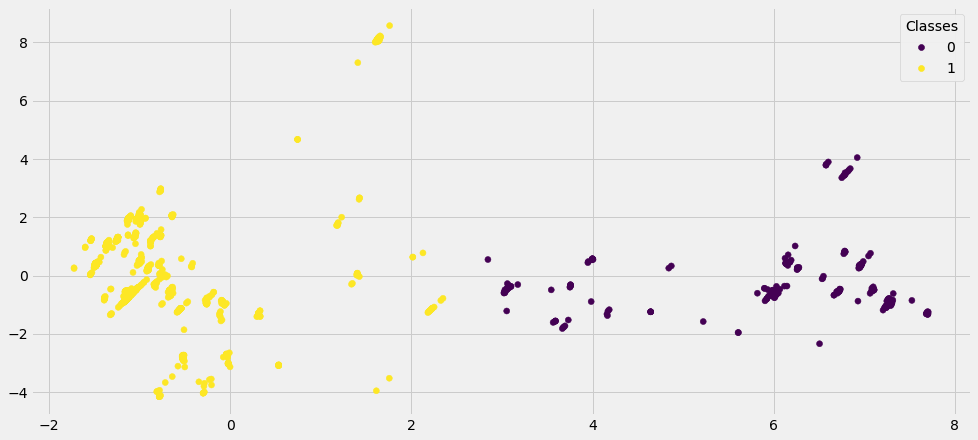

In [226]:
pca = PCA(n_components=2)
pca.fit(scaled_features)
X = pca.transform(scaled_features)

fig, ax = plt.subplots(figsize=(15,7))

scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(legend1)
plt.show()

Попробуем нарисать кластеры с процетной ставкой по купону

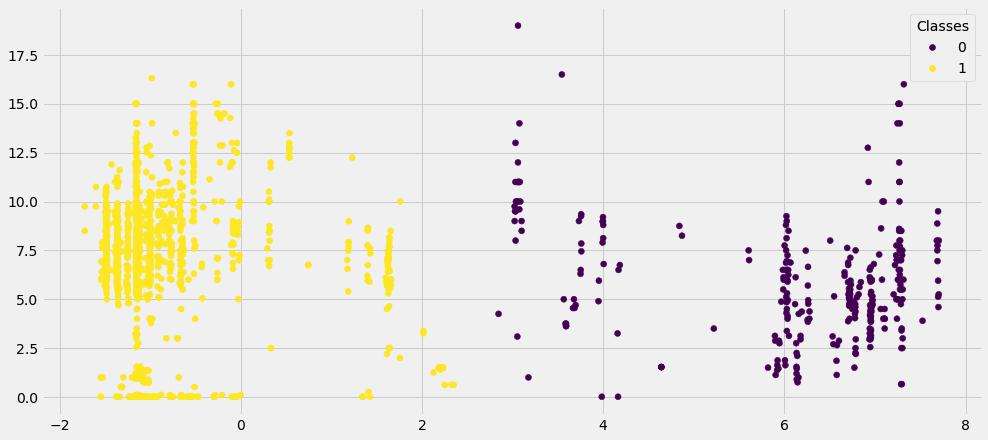

In [227]:
pca = PCA(n_components=1)
pca.fit(scaled_features)
X = pca.transform(scaled_features)


fig, ax = plt.subplots(figsize=(15,7))

scatter = ax.scatter(X, clustering_df.COUPONPERCENT, c=kmeans.labels_)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(legend1)
plt.show()

### Кластеризация низкорисковых рублевых облигаций

In [286]:
clustering_df = df.copy()
clustering_df = clustering_df[clustering_df.FACEUNIT == 'RUB']
clustering_df = clustering_df[clustering_df.IS_QUALIFIED_INVESTORS == 0]
clustering_df = clustering_df[clustering_df.HIGH_RISK == 0]
clustering_df = clustering_df[clustering_df.PRICE_RUB.notna()]

In [287]:
clustering_df = pd.get_dummies(clustering_df[CATEGORICAL_COLS + BINARY_COLS + ['PRICE', 'COUPONPERCENT']], columns=CATEGORICAL_COLS).dropna()

In [288]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_df)

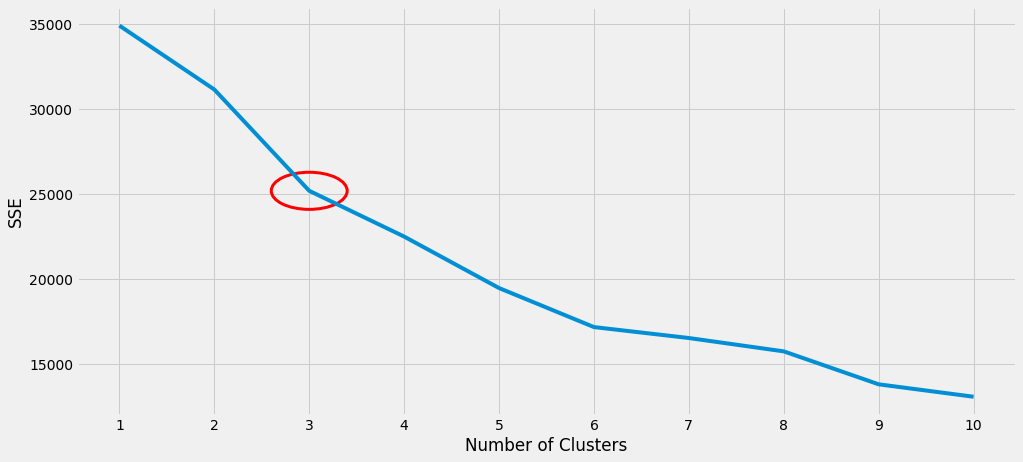

In [302]:
sse = []
kmeans_kwargs = {"init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 0}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(15,7))
ellipse = Ellipse((3, sse[2]), 
                  height=(max(sse) - min(sse)) / len(sse), 
                  width=0.8,
                  edgecolor='r',
                  fill=False,
                  linewidth=3)

ax.plot(range(1, 11), sse)
ax.add_patch(ellipse)
ax.set_xticks(range(1, 11))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")

plt.show()

In [303]:
kmeans = KMeans(init="random",
                n_clusters=3,
                n_init=10,
                max_iter=300,
                random_state=0)

kmeans.fit(scaled_features)
clustering_df['Cluster'] = kmeans.labels_
clustering_df.Cluster.value_counts()

1    876
2    796
0     73
Name: Cluster, dtype: int64

In [304]:
clustering_df[clustering_df.Cluster==0].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,TYPENAME_Муниципальные облигации,TYPENAME_ОБР,TYPENAME_ОФЗ,TYPENAME_Региональные облигации,LISTLEVEL_1,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_RUB,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQOB,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,73.000000,73.0,73.0,73.000000,73.0,73.000000,73.000000,73.0,73.000000,73.0,73.0,73.000000,73.000000,73.0,73.000000,73.0,73.000000,73.0,73.000000,73.000000,73.0,73.0,73.0,73.0,73.0
mean,0.726027,0.0,0.0,0.958904,0.0,97.736438,6.426205,0.0,0.315068,0.0,0.0,0.041096,0.643836,0.0,0.808219,0.0,0.191781,1.0,0.315068,0.684932,0.0,0.0,0.0,0.0,0.0
std,0.449082,0.0,0.0,0.199886,0.0,12.167166,2.188200,0.0,0.467758,0.0,0.0,0.199886,0.482179,0.0,0.396426,0.0,0.396426,0.0,0.467758,0.467758,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.000000,0.0,20.180000,0.010000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.0,0.0,1.000000,0.0,96.430000,5.930000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,1.000000,0.0,0.0,1.000000,0.0,98.830000,6.900000,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.0,1.000000,0.0,0.000000,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0
75%,1.000000,0.0,0.0,1.000000,0.0,100.130000,7.650000,0.0,1.000000,0.0,0.0,0.000000,1.000000,0.0,1.000000,0.0,0.000000,1.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0
max,1.000000,0.0,0.0,1.000000,0.0,143.980000,12.250000,0.0,1.000000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0


In [305]:
clustering_df[clustering_df.Cluster==1].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,TYPENAME_Муниципальные облигации,TYPENAME_ОБР,TYPENAME_ОФЗ,TYPENAME_Региональные облигации,LISTLEVEL_1,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_RUB,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQOB,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,876.000000,876.0,876.0,876.0,876.0,876.000000,876.000000,876.000000,876.0,876.000000,876.000000,876.0,876.0,876.000000,876.0,876.0,876.0,876.0,876.0,876.0,876.000000,876.000000,876.0,876.000000,876.0
mean,0.044521,0.0,0.0,0.0,0.0,99.819224,4.628775,0.876712,0.0,0.110731,0.003425,0.0,0.0,0.009132,0.0,0.0,1.0,1.0,1.0,0.0,0.022831,0.019406,0.0,0.012557,1.0
std,0.206366,0.0,0.0,0.0,0.0,12.619266,4.635760,0.328955,0.0,0.313977,0.058454,0.0,0.0,0.095181,0.0,0.0,0.0,0.0,0.0,0.0,0.149450,0.138027,0.0,0.111416,0.0
min,0.000000,0.0,0.0,0.0,0.0,13.000000,0.010000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
25%,0.000000,0.0,0.0,0.0,0.0,94.987500,0.010000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
50%,0.000000,0.0,0.0,0.0,0.0,99.860000,4.500000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
75%,0.000000,0.0,0.0,0.0,0.0,101.695000,8.462500,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
max,1.000000,0.0,0.0,0.0,0.0,198.210000,15.000000,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,1.000000,1.000000,0.0,1.000000,1.0


In [306]:
clustering_df[clustering_df.Cluster==2].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,TYPENAME_Муниципальные облигации,TYPENAME_ОБР,TYPENAME_ОФЗ,TYPENAME_Региональные облигации,LISTLEVEL_1,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_RUB,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQOB,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,796.000000,796.0,796.0,796.0,796.0,796.000000,796.000000,796.000000,796.0,796.000000,796.000000,796.0,796.0,796.000000,796.000000,796.000000,796.000000,796.0,796.0,796.0,796.000000,796.0,796.000000,796.000000,796.0
mean,0.231156,0.0,0.0,0.0,0.0,99.566256,7.578069,0.728643,0.0,0.129397,0.008794,0.0,0.0,0.133166,0.590452,0.408291,0.001256,1.0,1.0,0.0,0.032663,0.0,0.003769,0.005025,2.0
std,0.421837,0.0,0.0,0.0,0.0,5.020401,1.727378,0.444939,0.0,0.335850,0.093422,0.0,0.0,0.339967,0.492060,0.491827,0.035444,0.0,0.0,0.0,0.177866,0.0,0.061314,0.070754,0.0
min,0.000000,0.0,0.0,0.0,0.0,69.950000,0.010000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,2.0
25%,0.000000,0.0,0.0,0.0,0.0,98.117500,6.600000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,2.0
50%,0.000000,0.0,0.0,0.0,0.0,99.865000,7.600000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,2.0
75%,0.000000,0.0,0.0,0.0,0.0,100.492500,8.650000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,1.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,2.0
max,1.000000,0.0,0.0,0.0,0.0,162.760000,16.310000,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.0,1.000000,0.0,1.000000,1.000000,2.0


##### Различие между кластерами


**COUPONPERCENT**:

0 кластер - 7.58%

1 кластер - 4.63%

2 кластер - 6.33%

**TYPENAME**:

0 кластер - 71% Биржевые облигации

1 кластер - 87% Биржевые облигации

2 кластер - 94% ОФЗ

**LISTLEVEL**:

0 кластер - 100% 1 и 2 уровень

1 кластер - 100% 3 уровень

2 кластер - 94% 1 уровень


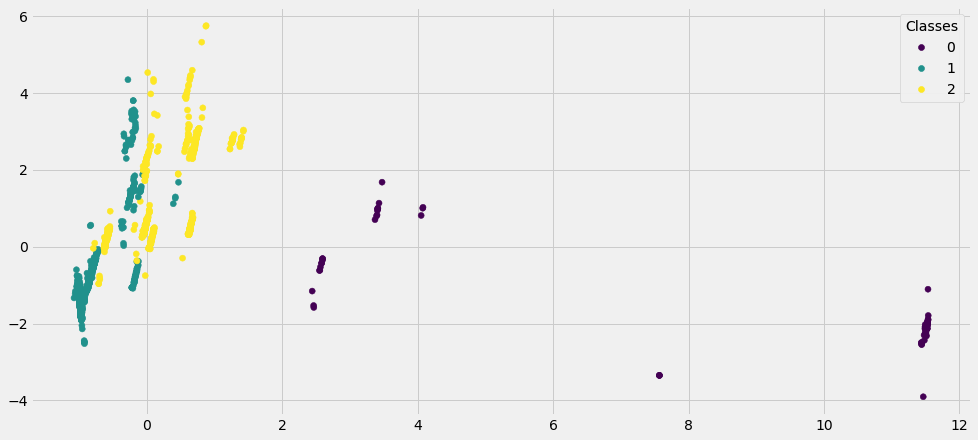

In [307]:
pca = PCA(n_components=2)
pca.fit(scaled_features)
X = pca.transform(scaled_features)

fig, ax = plt.subplots(figsize=(15,7))

scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(legend1)
plt.show()

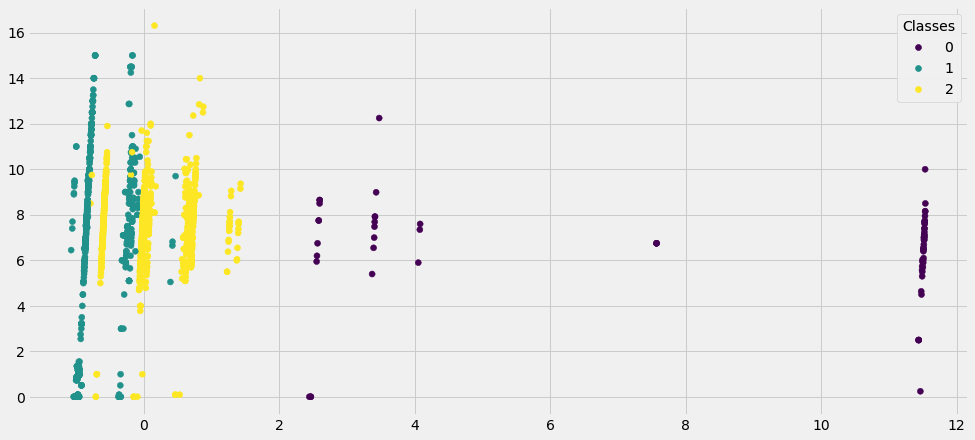

In [308]:
pca = PCA(n_components=1)
pca.fit(scaled_features)
X = pca.transform(scaled_features)


fig, ax = plt.subplots(figsize=(15,7))

scatter = ax.scatter(X, clustering_df.COUPONPERCENT, c=kmeans.labels_)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(legend1)
plt.show()

# Расчет доходности

### Фильтрация данных

In [31]:
df = df[df.FACEUNIT == 'RUB']
df = df[df.IS_QUALIFIED_INVESTORS == 0]
df = df[df.HIGH_RISK == 0]
df = df[df.PRICE_RUB.notna()]
df = df[(df.COUPONDAYSPASSED / df.COUPONLENGTH) <= 0.2]

,SECID,TYPENAME,LISTLEVEL,FACEVALUE,FACEUNIT,IS_COLLATERAL,IS_EXTERNAL,PRIMARY_BOARDID,MATDATE,IS_RII,DURATION,ISSUEDATE,EVENINGSESSION,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,YIELDATWAP,COUPONDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,ISSUEDATE.1,SECSUBTYPE,STARTDATEMOEX,DAYSTOREDEMPTION,OFFERDATE,PRICE,PRICE_RUB,RTL1,RTH1,RTL2,RTH2,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,MAX_INVEST_DATE,INVEST_DAYS,COUPON_INCOME,CURRENT_YIELD,PROFIT
17,RU000A0JQAM6,Корпоративные облигации,1,1000.0,RUB,0,0,TQCB,2028-09-15,NaN,1957.0,2009-08-27,0,0,0,2.0,"-15,82",2022-03-15,9.25,45.87,23.0,158.0,181.0,2009-08-27,NaN,NaT,2534.0,NaT,112.08,1126.63,675.98,1577.28,619.65,1633.61,563.32,1689.95,40.0,200000.0,45.0,1000000.0,50.0,10.0,10.0,2022-10-09,365.0,91.740000,5.828785,6.930867
26,RU000A0JRU20,Корпоративные облигации,3,851.0,RUB,0,0,TQCB,2031-09-26,NaN,1636.0,2011-10-21,0,0,0,2.0,NaN,2022-08-04,9.68,41.08,0.0,182.0,182.0,2011-10-21,NaN,2011-12-15,3640.0,NaT,94.70,805.90,NaN,1611.80,NaN,1611.80,NaN,1611.80,100.0,NaN,NaN,NaN,NaN,10.0,10.0,2022-10-09,365.0,82.160000,0.000000,8.925450
27,RU000A0JRU46,Корпоративные облигации,3,851.0,RUB,0,0,TQCB,2031-09-26,NaN,1636.0,2011-10-21,0,0,0,2.0,NaN,2022-08-04,9.68,41.08,0.0,182.0,182.0,2011-10-21,NaN,2011-12-15,3640.0,NaT,98.32,836.70,NaN,1673.40,NaN,1673.40,NaN,1673.40,100.0,NaN,NaN,NaN,NaN,10.0,10.0,2022-10-09,365.0,82.160000,0.000000,8.560081
31,RU000A0JRVU3,Корпоративные облигации,3,1000.0,RUB,0,0,TQCB,2022-05-04,NaN,179.0,2012-04-17,0,0,0,2.0,"8,16",2022-05-04,9.95,49.61,3.0,179.0,182.0,2012-04-17,NaN,2012-05-28,179.0,NaT,100.88,1009.62,NaN,2019.24,NaN,2019.24,NaN,2019.24,100.0,NaN,NaN,NaN,NaN,10.0,10.0,2022-05-04,207.0,56.269973,0.817747,4.834588
44,RU000A0JS5A7,Корпоративные облигации,3,1000.0,RUB,0,0,TQCB,2022-07-03,NaN,NaN,2012-03-19,0,0,0,2.0,NaN,2022-07-03,0.01,0.05,32.0,150.0,182.0,2012-03-19,NaN,2012-04-23,150.0,NaT,97.02,970.21,582.13,1358.29,553.02,1387.40,523.91,1416.51,40.0,200000.0,43.0,1000000.0,46.0,10.0,10.0,2022-07-03,267.0,0.073151,0.008791,0.037255


### Добавление

In [ ]:
df['MAX_INVEST_DATE'] = df.apply(lambda x: min(x.MATDATE, (date.today() + timedelta(days=INVEST_PERIOD))), axis=1)
df['INVEST_DAYS'] = df.apply(lambda x: (x.MAX_INVEST_DATE - (datetime.combine(date.today(), datetime.min.time()))).days, axis=1)
df['COUPON_INCOME'] = (df.INVEST_DAYS / 365) * df.COUPONFREQUENCY * df.COUPONVALUE
df['CURRENT_YIELD'] = df.COUPONVALUE * df.COUPONDAYSPASSED / df.COUPONLENGTH
df['PROFIT'] = (df.FACEVALUE - df.PRICE_RUB - df.CURRENT_YIELD + (1 - TAX_RATE) * df.COUPON_INCOME * 100) / (df.PRICE_RUB + df.CURRENT_YIELD)
df.head()

In [ ]:
df.sort_values(by='PROFIT', ascending=False)

In [ ]:
df.PROFIT.sort_values(ascending=False).values

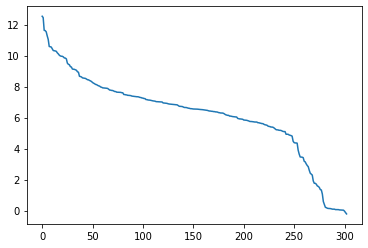

In [37]:
plt.plot(df.PROFIT.sort_values(ascending=False).values)

In [182]:
df.isna().sum()

SECID                       0
SHORTNAME                   0
NAME                        0
TYPENAME                    0
ISIN                        0
REGNUMBER                   6
LISTLEVEL                   0
FACEVALUE                   0
FACEUNIT                    0
ISSUESIZE                   0
IS_COLLATERAL               0
IS_EXTERNAL                 0
PRIMARY_BOARDID             0
PRIMARY_BOARD_TITLE         0
MATDATE                     1
IS_RII                    363
DURATION                   78
ISSUEDATE                   0
EVENINGSESSION              0
IS_QUALIFIED_INVESTORS      0
HIGH_RISK                   0
COUPONFREQUENCY            53
YIELDATWAP                157
COUPONDATE                  0
COUPONPERCENT              10
COUPONVALUE                10
COUPONDAYSPASSED            0
COUPONDAYSREMAIN            0
COUPONLENGTH                0
ISSUEDATE.1                 0
INITIALFACEVALUE            0
SECSUBTYPE                345
STARTDATEMOEX               4
DAYSTOREDE

In [ ]:
len(df)